In [3]:
from amalearn.reward import GaussianReward, RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import gym
import random

* Reward class:
    * This class keeps track of each paths reward. ex:0-1-5-8-12 is the path starting from links 0-1, 1-5, 5-8 and 8-12.
    * This class has each links color and delay distribution and each nodes congestion probability.
    * The get_reward method calculates rewards by sampling from link distribution, considering the link color and conjestion of each node.
* NArmedBanditEnvironment:
    * The select_action_epsilon method get a value p randomly between 0 to 1 and if it is less than the epsilon then it returns the best action otherwise it selects a random action.
    * The update_epsilon_selected_arm method updates the resulted Q value of the selected arm by adding alpha * (Ri - Q_value) which is a multiplier of the error.
    * The select_action_gradient method selects a random action from actions based on a probability equal to e^H/Zigma e^H
    * The update_gradient_selected_arm method updates the H of the optimal action by adding  alpha * (Ri - meanR) * (1 - e^H/Zigma e^H) and other actions by adding - alpha * (Ri - meanR) * e^H/Zigma e^H
* Agent_epsilonGreedy class:
    * This class has three variable one for epsilon, one for the alpha value and one array of calculated Q_values.
    * The take_action method selcts an arm with select_action_epsilon method of the environment and recieves the reward and updates the selected arm's Q_value with update_epsilon_selected_arm method.
* Agent_gradient class:
    * This class takes track of reward average, time and H for each action
    * The take_action method selcts an arm with select_action_gradient method of the environment and recieves the reward and updates the selected arm's H with update_gradient_selected_arm method and updates reward average and trial counts.


In [134]:
class Reward(RewardBase):
    def __init__(self, action, p, link_colors, links, mean_ogb, var_ogb):
        super(Reward, self).__init__()
        self.action = [action.split("-")[i]+"-"+action.split("-")[i+1] for i in range(len(action.split("-"))-1)]
        destination = [int(action.split("-")[i+1]) for i in range(4)]
        self.p = [p[node_id] for node_id in destination]
        path_colors = [link_colors[links.index(action.split("-")[i]+"-"+action.split("-")[i+1])] for i in range(len(action.split("-"))-1)]
        self.path_mean = [mean_ogb[["o","g","b"].index(color)] for color in path_colors]
        self.path_var = [var_ogb[["o","g","b"].index(color)] for color in path_colors]
    
    def get_reward(self):
        delay = [np.random.normal(loc=self.path_mean[i], scale=sqrt(self.path_var[i])) for i in range(len(self.path_var))]
        p = [10 if random.random()<self.p[i] else 0 for i in range(len(self.path_var))]
        delay = delay + p
        return -1 * np.sum(delay)
    
    def update(self, Ri):
        return

class NArmedBanditEnvironment(EnvironmentBase):
    def __init__(self, actions, link_colors, links, pi, mean_ogb, var_ogb, arm_count, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(arm_count)
        super(NArmedBanditEnvironment, self).__init__(action_space, state_space, id, container)
        self.arm_count = arm_count
        self.rewards = [Reward(actions[i], pi, link_colors, links, mean_ogb, var_ogb) for i in range(arm_count)]
        
    def sample_all_rewards(self):
        return
    
    def select_action_epsilon(self, epsilon, Q_value):
        p = random.random()
        if p< epsilon:
            return np.argmax(Q_value)
        else:
            return np.random.choice(self.arm_count)
    
    def select_action_gradient(self, H):
        d = np.sum(np.exp(H))
        return np.random.choice(a = [i for i in range(len(H))], p = np.exp(H)/d)
    
    def update_epsilon_selected_arm(self, index_selected_arm, Q_value, Ri, alpha):
        Q_value[index_selected_arm] = Q_value[index_selected_arm] + alpha * (Ri - Q_value[index_selected_arm])
        return Q_value
     
    def update_gradient_selected_arm(self, index_selected_arm, meanR, Ri, H, alpha):
        d = np.sum(np.exp(H))
        H = H - alpha * (Ri - meanR) * np.exp(H)/d
        H[index_selected_arm] = H[index_selected_arm] + alpha * (Ri - meanR)
        return H
    
    def calculate_reward(self, action):
        return self.rewards[action].get_reward()

    def terminated(self):
        return 

    def observe(self):
        return 

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        return

    def reset(self):
        return

    def render(self, mode='human'):
        #print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))
        return 

    def close(self):
        return
    
class Agent_epsilonGreedy(AgentBase):
    def __init__(self,epsilon, environment, alpha, id):
        self.epsilon = epsilon
        self.Q_value = np.zeros(environment.arm_count)
        super(Agent_epsilonGreedy, self).__init__(id, environment)
        self.alpha = alpha
        
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = self.environment.select_action_epsilon(self.epsilon, self.Q_value)
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        self.Q_value = self.environment.update_epsilon_selected_arm(index_selected_arm, self.Q_value, Ri, self.alpha)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i
class Agent_gradient(AgentBase):
    def __init__(self, id, environment):
        self.meanR = 0
        self.H = np.zeros(environment.arm_count)
        super(Agent_gradient, self).__init__(id, environment)
        self.t = 0
        
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = self.environment.select_action_gradient(self.H)
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        self.H = self.environment.update_gradient_selected_arm(index_selected_arm, self.meanR, Ri, self.H, 0.1)
        self.meanR = self.meanR * self.t + Ri
        self.t = self.t + 1
        self.meanR = self.meanR/ self.t
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

Defining actions, link colors, color delay distributions and probabilities and running epsilon greedy 20 time for 1000 trials.

In [147]:
def epsilon_greedy_run(epsilon):
    agent = Agent_epsilonGreedy(epsilon, env, 0.1, '1')
    mean_reward_epsilon = []
    reward = []
    for i in range(20):
        mr = [0]
        tr = []
        for step in range(1000):
            _,r,_,_ = agent.take_action()
            mr.append((mr[step]*step+r)/(step+1))
            tr.append(r)
        mean_reward_epsilon.append(mr)
        reward.append(tr)
    return agent, mean_reward_epsilon, reward

best path epsilon:0.001
0-2-5-10-12delay:10.388295875644909
best path epsilon:0.01
0-2-5-8-12delay:9.810727636086277
best path epsilon:0.1
0-2-5-8-12delay:9.632761276919123


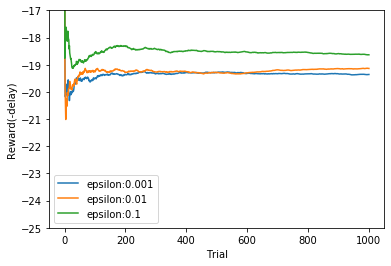

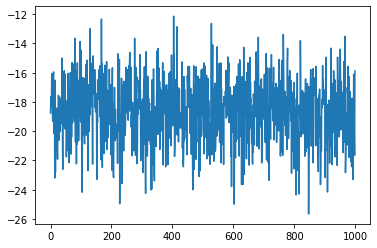

In [133]:
actions = ["0-1-5-8-12","0-1-5-9-12","0-1-5-10-12","0-1-5-11-12","0-1-6-8-12","0-1-6-9-12","0-1-6-10-12","0-1-6-11-12","0-1-7-8-12","0-1-7-9-12","0-1-7-10-12","0-1-7-11-12","0-2-5-8-12","0-2-5-9-12","0-2-5-10-12","0-2-5-11-12","0-2-6-8-12","0-2-6-9-12","0-2-6-10-12","0-2-6-11-12","0-2-7-8-12","0-2-7-9-12","0-2-7-10-12","0-2-7-11-12","0-3-5-8-12","0-3-5-9-12","0-3-5-10-12","0-3-5-11-12","0-3-6-8-12","0-3-6-9-12","0-3-6-10-12","0-3-6-11-12","0-3-7-8-12","0-3-7-9-12","0-3-7-10-12","0-3-7-11-12","0-4-5-8-12","0-4-5-9-12","0-4-5-10-12","0-4-5-11-12","0-4-6-8-12","0-4-6-9-12","0-4-6-10-12","0-4-6-11-12","0-4-7-8-12","0-4-7-9-12","0-4-7-10-12","0-4-7-11-12"]
link_colors = ['g','b','g','o','g','b','b','b','o','o','g','o','b','o','g','g','o','o','b','b','g','g','b','b','o','o','g','g','b','o','g','o']
#std_ID = 810199252
mean_ogb = [2,5,2]
var_ogb = [9.5,3,5.2]
links = ["0-1","0-2","0-3","0-4","1-5","1-6","1-7","2-5","2-6","2-7","3-5","3-6","3-7","4-5","4-6","4-7","5-8","5-9","5-10","5-11","6-8","6-9","6-10","6-11","7-8","7-9","7-10","7-11","8-12","9-12","10-12","11-12"]
pi = [0,0.1,0.06,0.15,0.5,0.1,0.15,0.65,0.12,0.2,0.05,0.45,0]
#print([(l, c) for l, c in zip(links, link_colors)])
env = NArmedBanditEnvironment(actions, link_colors, links, pi, mean_ogb, var_ogb, len(actions), 1)
agent2 = Agent_gradient('2', env)
for epsilon in [0.001, 0.01, 0.1]:
    agent, mean_reward_epsilon , r = epsilon_greedy_run(epsilon)
    plt.plot([i for i in range(1001)], np.mean(mean_reward_epsilon,axis=0), label = "epsilon:"+str(epsilon))
    print("best path epsilon:"+str(epsilon))
    print(str(actions[np.argmax(agent.Q_value)]) + "delay:"+ str(-1*np.max(agent.Q_value)))
plt.xlabel("Trial")
plt.ylabel("Reward(-delay)")
plt.ylim((-25,-17))
plt.legend()
plt.show()
plt.plot([i for i in range(1000)], np.mean(r,axis=0))
plt.show()

Running gradient agent for 20 time 1000 trials.

best path gradient:
0-2-5-9-12


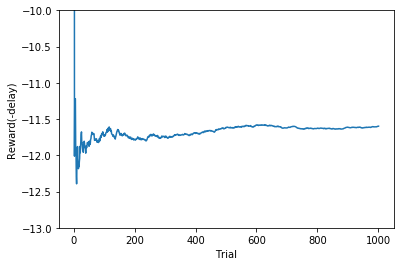

In [155]:
mean_reward_gradient = []
for i in range(20):
    env = NArmedBanditEnvironment(actions, link_colors, links, pi, mean_ogb, var_ogb, len(actions), 1)
    mr = [0]
    for step in range(1000):
        _,r,_,_ = agent2.take_action()
        mr.append((mr[step]*step+r)/(step+1))
    mean_reward_gradient.append(mr)
print("best path gradient:")
print(actions[np.argmax(agent2.H)])
plt.plot([i+1 for i in range(1001)], np.mean(mean_reward_gradient,axis=0))
plt.xlabel("Trial")
plt.ylabel("Reward(-delay)")
plt.ylim((-13,-10))
plt.show()

Finding the best 3 paths through sampling rewards multiple times.

In [147]:
actions = ["0-1-5-8-12","0-1-5-9-12","0-1-5-10-12","0-1-5-11-12","0-1-6-8-12","0-1-6-9-12","0-1-6-10-12","0-1-6-11-12","0-1-7-8-12","0-1-7-9-12","0-1-7-10-12","0-1-7-11-12","0-2-5-8-12","0-2-5-9-12","0-2-5-10-12","0-2-5-11-12","0-2-6-8-12","0-2-6-9-12","0-2-6-10-12","0-2-6-11-12","0-2-7-8-12","0-2-7-9-12","0-2-7-10-12","0-2-7-11-12","0-3-5-8-12","0-3-5-9-12","0-3-5-10-12","0-3-5-11-12","0-3-6-8-12","0-3-6-9-12","0-3-6-10-12","0-3-6-11-12","0-3-7-8-12","0-3-7-9-12","0-3-7-10-12","0-3-7-11-12","0-4-5-8-12","0-4-5-9-12","0-4-5-10-12","0-4-5-11-12","0-4-6-8-12","0-4-6-9-12","0-4-6-10-12","0-4-6-11-12","0-4-7-8-12","0-4-7-9-12","0-4-7-10-12","0-4-7-11-12"]
link_colors = ['g','b','g','o','g','b','b','b','o','o','g','o','b','o','g','g','o','o','b','b','g','g','b','b','o','o','g','g','b','o','g','o']
#std_ID = 810199252
mean_ogb = [2,5,2]
var_ogb = [9.5,3,5.2]
links = ["0-1","0-2","0-3","0-4","1-5","1-6","1-7","2-5","2-6","2-7","3-5","3-6","3-7","4-5","4-6","4-7","5-8","5-9","5-10","5-11","6-8","6-9","6-10","6-11","7-8","7-9","7-10","7-11","8-12","9-12","10-12","11-12"]
pi = [0,0.1,0.06,0.15,0.5,0.1,0.15,0.65,0.12,0.2,0.05,0.45,0]
def func(actions, link_colors, links, pi, mean_ogb, var_ogb, arm_count, id, container=None):
    rewards = [Reward(actions[i], pi, link_colors, links, mean_ogb, var_ogb) for i in range(arm_count)]
    mean = np.zeros(arm_count)
    for i in range(1000):
        mean = [(mean[j]*(i) + rewards[j].get_reward())/(i+1) for j in range(arm_count)]
    ind = np.argpartition(mean, -3)[-3:]
    print(actions[ind[0]]+":"+str(mean[0]))
    print(actions[ind[1]]+":"+str(mean[1]))
    print(actions[ind[2]]+":"+str(mean[2]))
func(actions, link_colors, links, pi, mean_ogb, var_ogb, len(actions), 1)

0-2-5-10-12:-17.473542248101058
0-2-5-8-12:-17.90938389493752
0-2-5-9-12:-19.71188108039633
